# Recoinize

[https://github.com/nicknochnack/FaceRecognition](https://github.com/nicknochnack/FaceRecognition/blob/main/Facial%20Verification%20with%20a%20Siamese%20Network%20-%20Final.ipynb)

# Setup

## Pull code from GitHub

In [ ]:
%load_ext autoreload
%autoreload 2

from src.helpers.cmd import git_update, print_gpu_name
from src.helpers.install import install_requirements
# git_update("live-edit", force=False, show_output=False)
# install_requirements()

In [53]:
!git fetch
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), 399 bytes | 0 bytes/s, done.
From https://github.com/photonsquid/Recoinize
   00b7297..ae7dbb3  live-edit  -> origin/live-edit
Updating 00b7297..ae7dbb3
Fast-forward
 src/dataset.py | 8 ++++----
 1 file changed, 4 insertions(+), 4 deletions(-)


In [7]:
print_gpu_name()

'Quadro P5000\n'

## Import dependencies

In [47]:
testing = False

In [48]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

# Import tensorflow dependencies - Functional API
if not testing:
    import tensorflow as tf
    from tensorflow import keras
    from keras.layers import Dense, Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
    from keras.models import Sequential, load_model, Model
    from datasets import load_dataset

    from src.models import make_embedding, make_siamese_model
    from src.helpers.setup import set_gpus_growth
    from src.dataset import create_pairs
    from src.preprocess import preprocess

    set_gpus_growth()
else:
    print("Testing mode, skipping tensorflow imports")
    from src.helpers.load_data import load_data
    from src.dataset import create_pairs


# Get and preprocess data

In [54]:
# Load the dataset from HuggingFace
if not testing:
    dataset = load_dataset('photonsquid/coins-euro')
else:
    # load data from local files
    dataset = load_data("data/tests")

Using custom data configuration photonsquid--coins-euro-489cfaace7f3d545
Reusing dataset parquet (/root/.cache/huggingface/datasets/photonsquid___parquet/photonsquid--coins-euro-489cfaace7f3d545/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/3 [00:00<?, ?it/s]

In [55]:
# Split the dataset into train and test
train_dataset = dataset['train']
test_dataset = dataset['test']

In [56]:
train_dataset[0]['objects']

{'value': '10cents', 'country': 'ad', 'edition': 'standard', 'variant': '0'}

In [57]:
# create the pairs and labels for the training dataset
train_dataset = create_pairs(train_dataset)

# convert it to a tensorflow dataset
# train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)

KeyError: '1cent'

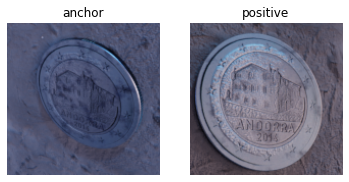

In [21]:
# show first pair in subplot with plt
plt.subplot(1, 2, 1)
plt.imshow(train_dataset[0][0])
plt.axis('off')
plt.title("anchor")
plt.subplot(1, 2, 2)
plt.imshow(train_dataset[0][1])
plt.axis('off')
plt.title("positive" if sum(train_dataset[0][2]) == 5 else "negative")
plt.rcParams['figure.facecolor'] = '#282A36'
plt.rcParams['text.color'] = '#ecf0f1'
plt.show()

In [ ]:
# prepare the dataset for training
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# prepare the dataset for testing
test_dataset = test_dataset.shuffle(1000)
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)